In [496]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import radius_neighbors_graph, kneighbors_graph
import networkx as nx
import scipy
import numpy as np
import plotly.graph_objs as go
import plotly.offline as pyo

In [497]:
data_path = '/home/avsngh/Mathematical Statistics/Masters-Projects/Unsupervised-Learning/Data/Star_Data.txt'
data = pd.read_csv(filepath_or_buffer=data_path, sep='\s+', header=None)
data.columns = ['col1','col2']
data_df=pd.DataFrame.from_dict(data)
data_df

<>:2: SyntaxWarning:

invalid escape sequence '\s'

<>:2: SyntaxWarning:

invalid escape sequence '\s'

/tmp/ipykernel_912/159696598.py:2: SyntaxWarning:

invalid escape sequence '\s'



,col1,col2
0,5.19535,-0.391847
1,2.12696,-0.348876
2,3.25733,-0.306237
3,-5.04634,-0.206221
4,-4.42945,0.635461
...,...,...
295,3.67002,7.279940
296,4.12115,4.639100
297,3.32121,3.888330
298,3.87897,5.469400


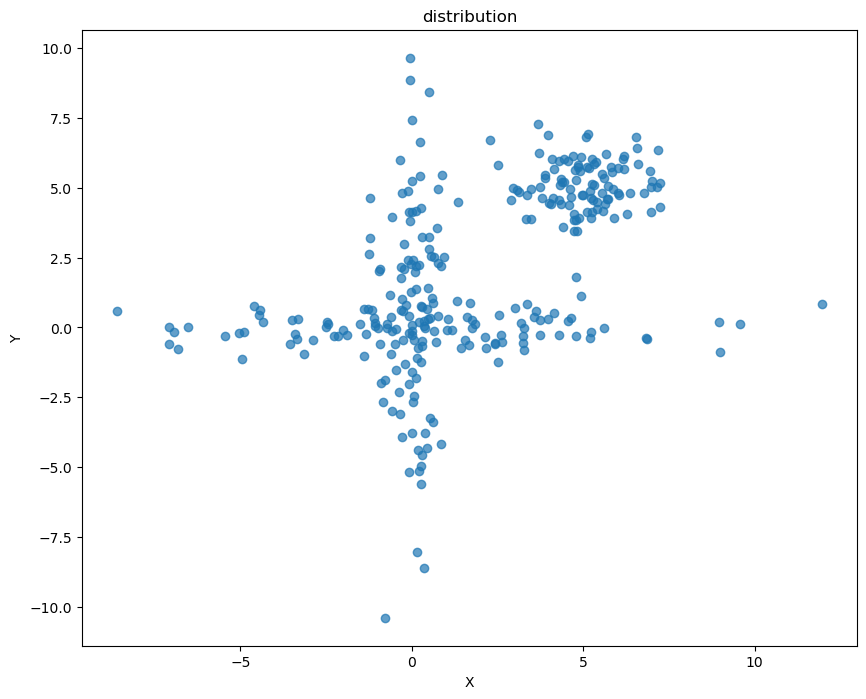

In [498]:
plt.figure(figsize=(10,8))
plt.scatter(data_df['col1'], data_df['col2'], marker='o', alpha=0.7)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('distribution')
plt.show()


## Creating ε neighbourhood graph

In [499]:
epsilon = 1.6
sim_matrix = radius_neighbors_graph(X=data_df, radius= epsilon, mode='distance', metric='euclidean', n_jobs=-1)

In [500]:
print(sim_matrix.getrow(4))

  (0, 96)	1.5024833966034368
  (0, 65)	1.3984427854853412
  (0, 9)	1.3450742858682565
  (0, 48)	1.496699105724327
  (0, 3)	1.0435429369335982
  (0, 25)	0.9379410647796587
  (0, 71)	1.0178618074886199
  (0, 40)	1.1669890704561035
  (0, 45)	0.45366430076544484
  (0, 10)	0.17996734291531902
  (0, 35)	0.22666018379062497


In [501]:
# using networkx library we create a graph which we will visualize in the next step
nx_graph = nx.from_scipy_sparse_array(sim_matrix)
coordinates_dict={}
coordinates_dict = {i: [data_df.at[i, 'col1'], data_df.at[i, 'col2']] for i in range(len(data))}


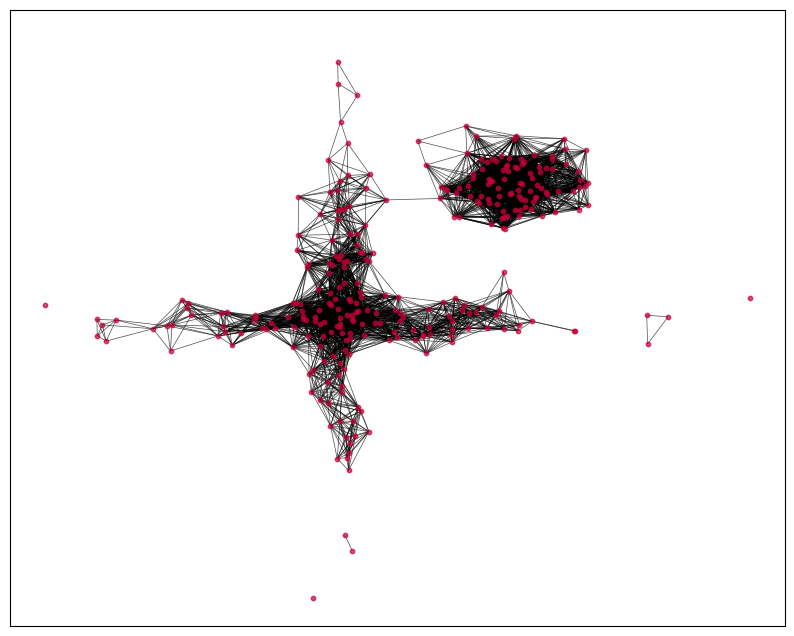

In [502]:
plt.figure(figsize=(10, 8))
nx.draw_networkx(G=nx_graph,pos=coordinates_dict, with_labels= False, node_size = 10, node_color= '#C70039', alpha = 0.7, width =0.5)

plt.show()

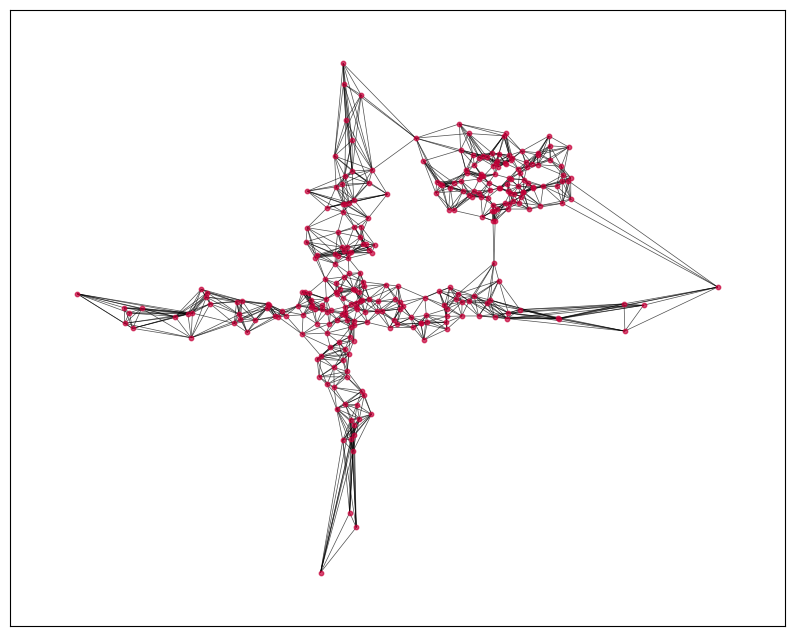

In [503]:
neighbours = 8
sim_matrix_knn = kneighbors_graph(X=data_df, n_neighbors=neighbours, mode='distance', metric='euclidean', n_jobs=-1)
nx_graph_knn = nx.from_scipy_sparse_array(sim_matrix_knn)

mutual_knn_graph =sim_matrix_knn.multiply(sim_matrix_knn.transpose())
nx_graph_mknn = nx.from_scipy_sparse_array(mutual_knn_graph)
plt.figure(figsize=(10, 8))
nx.draw_networkx(G=nx_graph_knn,pos=coordinates_dict, with_labels= False, node_size = 10, node_color= '#C70039', alpha = 0.7, width =0.5)

plt.show()

In [583]:
def create_degree_matrix(csr_weight_matrix):
    number_of_vertices = csr_weight_matrix.get_shape()[0]
    degree_sums = []
    for i in range(number_of_vertices):
        degree = scipy.sparse.csr_matrix.sum(csr_weight_matrix.getcol(i))
        degree_sums.append(degree)
    degree_matrix = np.diag(degree_sums)
    return degree_matrix

def eigenspace_calculation(matrix, k: int = 1):
    np.random.seed(42)
    v0 = np.random.rand(matrix.shape[0])
    eigenvals,eigenvects = scipy.sparse.linalg.eigs(matrix, k=k, which='SM', v0=v0, maxiter=6000)
    return eigenvals, eigenvects


In [584]:
degree_matrix = create_degree_matrix(sim_matrix_knn)


In [585]:
unnorm_laplacian_matrix=degree_matrix-sim_matrix_knn
unnorm_laplacian_matrix
dense_unnorm = np.asarray(unnorm_laplacian_matrix)

In [586]:
eigv, eigvec = scipy.linalg.eig(dense_unnorm)

In [588]:

eigenvals,eigenvects = eigenspace_calculation(matrix=unnorm_laplacian_matrix, k=4)



In [589]:
eigenvector_1=eigenvects[:,1]
eigenvector_2=eigenvects[:,2]
two_eig_df = pd.DataFrame(np.column_stack((eigenvector_1, eigenvector_2)), columns=['eigenvect1', 'eigenvect2'])
two_eig_df


,eigenvect1,eigenvect2
0,3.708859e-04+0.000000e+ 00j,-0.000494+0.000000j
1,5.550796e-05+0.000000e+ 00j,-0.000052+0.000000j
2,9.029957e-05+0.000000e+ 00j,-0.000096+0.000000j
3,7.115524e-04+0.000000e+ 00j,-0.001408+0.000000j
4,2.659276e-04+0.000000e+ 00j,-0.000525+0.000000j
...,...,...
295,1.612975e-04+0.000000e+ 00j,0.001321+0.000000j
296,2.058160e-07+0.000000e+ 00j,0.000002+0.000000j
297,2.757732e-05+0.000000e+ 00j,0.000226+0.000000j
298,3.044908e-07+0.000000e+ 00j,0.000002+0.000000j


In [590]:
epsilon = 1e-12

# Count eigenvalues close to zero
zero_eigenvalues = np.sum(np.abs(eigenvals) < epsilon)
print(f"Number of zero eigenvalues: {zero_eigenvalues}")


Number of zero eigenvalues: 1


/home/avsngh/anaconda3/envs/msenv/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning:

Casting complex values to real discards the imaginary part

/home/avsngh/anaconda3/envs/msenv/lib/python3.12/site-packages/pandas/core/series.py:1031: ComplexWarning:

Casting complex values to real discards the imaginary part

/home/avsngh/anaconda3/envs/msenv/lib/python3.12/site-packages/matplotlib/collections.py:197: ComplexWarning:

Casting complex values to real discards the imaginary part



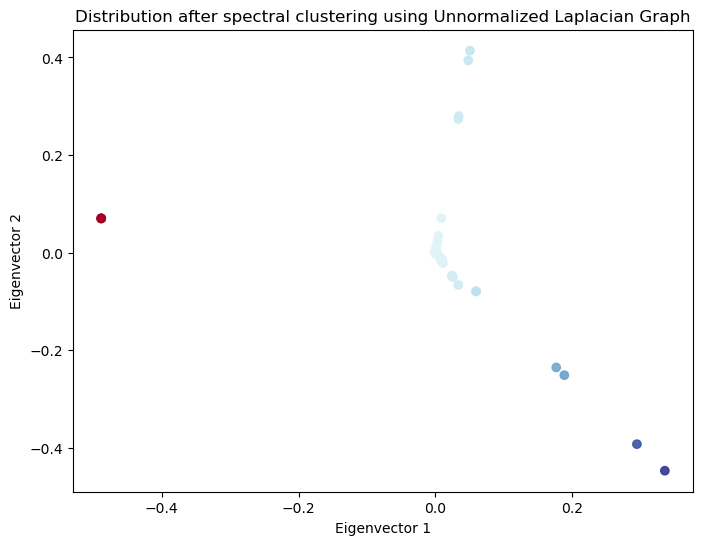

In [591]:
plt.figure(figsize=(8,6))
plt.scatter(two_eig_df['eigenvect1'], two_eig_df['eigenvect2'], marker='o', alpha=0.9, c=two_eig_df['eigenvect1'], cmap='RdYlBu')
plt.xlabel('Eigenvector 1')
plt.ylabel('Eigenvector 2')
plt.title('Distribution after spectral clustering using Unnormalized Laplacian Graph')
plt.show()

### Part 1.C

In [592]:
D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(degree_matrix)))

# Calculate D^(-1/2) * L * D^(-1/2)
normalized_L = D_inv_sqrt @ unnorm_laplacian_matrix @ D_inv_sqrt


In [593]:
norm_eigenvals, norm_eigenvects = eigenspace_calculation(matrix=normalized_L, k=3)
norm_eigenvector_1=norm_eigenvects[:,1]
norm_eigenvector_2=norm_eigenvects[:,2]
norm_two_eig_df = pd.DataFrame(np.column_stack((norm_eigenvector_1, norm_eigenvector_2)), columns=['eigenvect1', 'eigenvect2'])


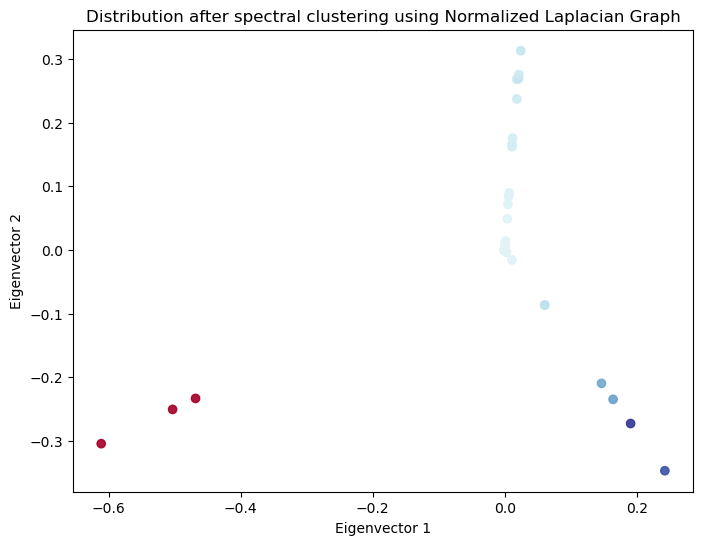

In [594]:
plt.figure(figsize=(8,6))
plt.scatter(norm_two_eig_df['eigenvect1'], norm_two_eig_df['eigenvect2'], marker='o', alpha=0.9, c=two_eig_df['eigenvect1'], cmap='RdYlBu')
plt.xlabel('Eigenvector 1')
plt.ylabel('Eigenvector 2')
plt.title('Distribution after spectral clustering using Normalized Laplacian Graph')
plt.show()

## Part 2

In [595]:
data_path = '/home/avsngh/Mathematical Statistics/Masters-Projects/Unsupervised-Learning/Data/Swiss_Roll.txt'
swiss_roll_data = pd.read_csv(filepath_or_buffer=data_path, sep='\s+', header=None)
swiss_roll_data.columns = ['col1','col2', 'col3']
swiss_roll_data_df=pd.DataFrame.from_dict(swiss_roll_data)
swiss_roll_data_df

<>:2: SyntaxWarning:

invalid escape sequence '\s'

<>:2: SyntaxWarning:

invalid escape sequence '\s'

/tmp/ipykernel_912/3840460807.py:2: SyntaxWarning:

invalid escape sequence '\s'



,col1,col2,col3
0,12.197324,22.314678,-2.215860
1,10.306112,26.698399,8.415810
2,5.529488,7.264337,-2.154041
3,9.725343,3.879517,9.145235
4,-3.381359,6.643389,-10.067453
...,...,...,...
1995,1.117341,6.247056,-4.861576
1996,-5.991543,1.199095,6.204610
1997,6.566627,14.097940,-9.532333
1998,10.685510,4.475016,-5.682815


In [596]:
colors = swiss_roll_data_df['col1']+swiss_roll_data_df['col3']
trace = go.Scatter3d(x=swiss_roll_data_df['col1'], y=swiss_roll_data_df['col2'], z=swiss_roll_data_df['col3'], 
                     mode='markers', marker=dict(size=3, color=colors, colorscale='plasma', opacity=0.8))
layout = go.Layout(title='3D Scatter Plot', margin=dict(l=0, r=0, b=0, t=0))
fig = go.Figure(data=[trace], layout=layout)

# Showing the plot
pyo.init_notebook_mode(connected=True)
pyo.iplot(fig)

In [597]:
sim_matrix_knn_2 = kneighbors_graph(X=swiss_roll_data_df, n_neighbors=6, mode='distance', metric='euclidean', n_jobs=-1)
degree_matrix_2 = create_degree_matrix(sim_matrix_knn_2)
unnorm_laplacian_matrix_2=degree_matrix_2-sim_matrix_knn_2
unnorm_laplacian_matrix_2

matrix([[4.43019192, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 8.49469354, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 9.41986762, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 7.18499102, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 6.02376081,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         3.50391903]])

In [598]:
eigenvals,eigenvects = eigenspace_calculation(matrix=unnorm_laplacian_matrix_2, k=9)


In [599]:
eigenvector_1=eigenvects[:,1]
eigenvector_2=eigenvects[:,2]
two_eig_df_2 = pd.DataFrame(np.column_stack((eigenvector_1, eigenvector_2)), columns=['eigenvect1', 'eigenvect2'])

/home/avsngh/anaconda3/envs/msenv/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning:

Casting complex values to real discards the imaginary part

/home/avsngh/anaconda3/envs/msenv/lib/python3.12/site-packages/pandas/core/series.py:1031: ComplexWarning:

Casting complex values to real discards the imaginary part

/home/avsngh/anaconda3/envs/msenv/lib/python3.12/site-packages/matplotlib/collections.py:197: ComplexWarning:

Casting complex values to real discards the imaginary part



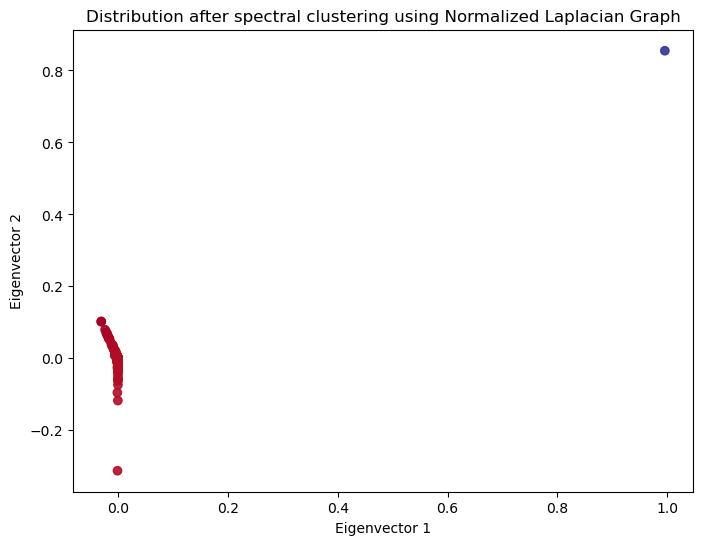

In [600]:
plt.figure(figsize=(8,6))
plt.scatter(x=two_eig_df_2['eigenvect1'], y=two_eig_df_2['eigenvect2'], marker='o', alpha=0.9, c=two_eig_df_2['eigenvect1'], cmap='RdYlBu')
plt.xlabel('Eigenvector 1')
plt.ylabel('Eigenvector 2')
plt.title('Distribution after spectral clustering using Normalized Laplacian Graph')
plt.show()

In [601]:
epsilon = 1e-12

# Count eigenvalues close to zero
zero_eigenvalues = np.sum(np.abs(eigenvals) < epsilon)
print(f"Number of zero eigenvalues: {zero_eigenvalues}")

Number of zero eigenvalues: 1


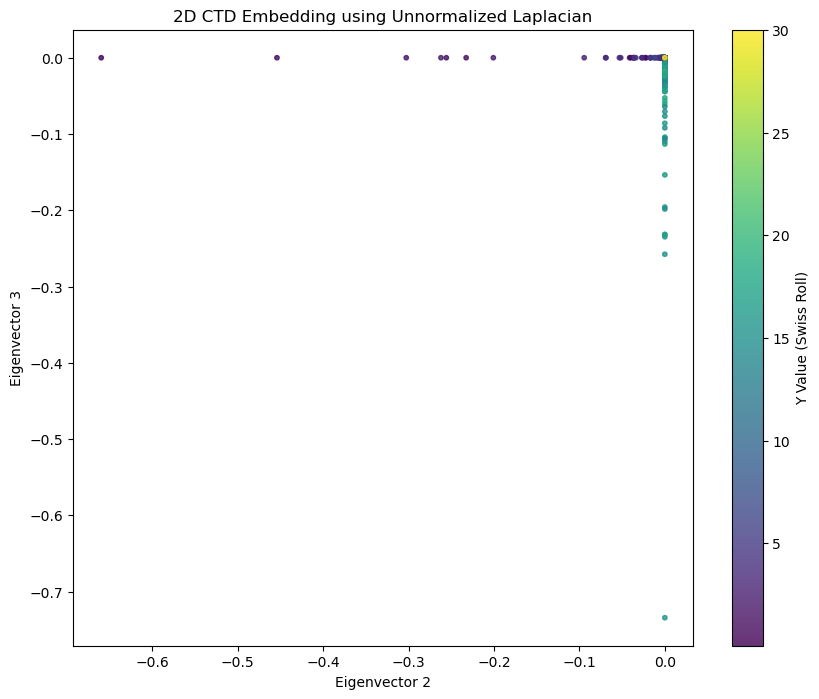

In [602]:
from scipy.sparse.csgraph import laplacian
from scipy.linalg import eigh

L, diag = laplacian(sim_matrix_knn_2, return_diag=True)

# Compute the eigenvalues and eigenvectors of the unnormalized Laplacian
eigenvalues, eigenvectors = eigh(L.toarray())

# Use the second and third smallest eigenvectors for the 2D embedding
embedding = eigenvectors[:, 1:3]

# Plot the 2D CTD embedding
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=swiss_roll_data_df['col2'], cmap='viridis', s=10, alpha=0.8)
plt.title('2D CTD Embedding using Unnormalized Laplacian')
plt.xlabel('Eigenvector 2')
plt.ylabel('Eigenvector 3')
plt.colorbar(label='Y Value (Swiss Roll)')
plt.show()

In [603]:
D_inv_sqrt_2 = np.diag(1.0 / np.sqrt(np.diag(degree_matrix_2)))

n = 2000  # Example value for n
# Create an n x n identity matrix using np.identity()
identity_matrix = np.identity(n)
# Calculate D^(-1/2) * L * D^(-1/2)
normalized_L_2 = identity_matrix - D_inv_sqrt_2 @ sim_matrix_knn_2 @ D_inv_sqrt_2
normalized_L_2[0][2]

/tmp/ipykernel_912/4164292023.py:1: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_912/4164292023.py:7: RuntimeWarning:

invalid value encountered in matmul



0.0

In [ ]:
norm_eigenvals_2, norm_eigenvects_2 = eigenspace_calculation(matrix=normalized_L_2, k=50)
norm_eigenvector_1=norm_eigenvects[:,1]
norm_eigenvector_2=norm_eigenvects[:,2]


In [ ]:
norm_two_eig_df = pd.DataFrame(np.column_stack((norm_eigenvector_1, norm_eigenvector_2)), columns=['eigenvect1', 'eigenvect2'])